In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


### Initialization

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

# agg = pd.DataFrame({'actual':elec.sum(axis=1)})
aggregate = pd.Series(elec.sum(axis=1))

### Transformation of median-shifting features

The neural network will perform better on stationary data. Electricity demand data is never stationary, because it includes seasonal (daily, weekly, yearly) and trend (steady/exponential increase) effects.

The following cells make the data stationary by calculating and then removing the hour-of-week (weekend vs weekday) and week-of-year (spring break vs class in session) effects.

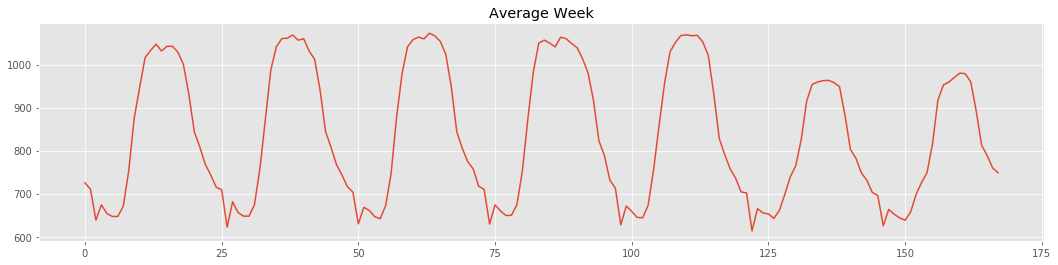

In [3]:
# calculate hour-of-week and week-of-year averages to isolate weekend, holiday median-shifting
hourofweekarray, hourofweek = range(168),range(1,168) # 2018 starts on a thursday
while len(hourofweek) < 10000: hourofweek = np.append(hourofweek,hourofweekarray)
hourofweek = hourofweek[:4991]

avg_week = aggregate.groupby(hourofweek).mean()
aggregate_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = aggregate.groupby(aggregate.index.weekofyear).mean()
aggregate_year_transformer = aggregate.index.weekofyear.map(avg_year)
aggregate_stationary = aggregate/aggregate_week_transformer/aggregate_year_transformer

# plot the average week
avg_week.plot(figsize=(18,4),title="Average Week")

### Forecasting with a Recurrent Neural Network

This notebook implements multi-step forecasting using a neural network. The following cell prepares the data for the neural network. X includes the previous 168 hourly values (one week of data) and 9 calendar features for an input dimension of 177. The output, y, includes 39 forecasted values for the target day.

This cell is annoying slow right now. I believe the method I use to populate X and y is extremely inefficient. Switching to column operations would be a necessary improvement for larger datasets.

In [4]:
# training length params
start = pd.to_datetime('2018-01-10 09:00:00')
end = pd.to_datetime('2018-7-10 09:00:00')
all_days = pd.date_range(start=start,end=end,freq='D')

X_cols = ['t-'+str(i) for i in range(1,169)]
y_cols = ['t+'+str(i) for i in range(0,39)]

# create dataframes structured for multi-step batch input
X = pd.DataFrame(index=all_days,columns=X_cols)
y = pd.DataFrame(index=all_days,columns=y_cols)

# populate dataframes with electricity loads
for i in all_days:
    for j in range(168):
        X.loc[i,X_cols[j]] = aggregate[i-pd.Timedelta(hours=j)]
    for k in range(39):
        y.loc[i,y_cols[k]] = aggregate[i+pd.Timedelta(hours=k)]

# day of week features
days = ['mon','tues','wed','thurs','fri','sat','sun']
for i in range(7):
    X[days[i]] = (np.array([i]*len(X))==np.asarray(X.index.dayofweek)).astype(int)

# feature for school breaks
X['break'] = (X.index.isin(pd.date_range(start='01/01/2018',end='01/15/2018',freq='H'))
              |X.index.isin(pd.date_range(start='03/10/2018',end='03/25/2018',freq='H'))
              |X.index.isin(pd.date_range(start='05/10/2018',end='08/22/2018',freq='H'))
             ).astype(int)

# feature for office holidays: MLK day, memorial day, 4th of july
X['holiday'] = (X.index.isin(pd.date_range(start='01/15/2018',end='01/16/2018',freq='H'))
                |X.index.isin(pd.date_range(start='05/28/2018',end='05/29/2018',freq='H'))
                |X.index.isin(pd.date_range(start='07/04/2018',end='07/05/2018',freq='H'))
               ).astype(int)

X = X.astype(float)
y = y.astype(float)

In [5]:
# define the parameters of the model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=177))
model.add(Dense(39))
model.compile(optimizer='adam', loss='mse')

In [11]:
# forecast for each day in the range
forecasts = pd.Series(elec.sum(axis=1))
num_days = 50
start = pd.to_datetime('2018-01-10 09:00:00')
test_days = pd.date_range(start=start,periods=num_days+1,freq='D')

for i in range(num_days):
    X_train = X.loc[:test_days[i]].values
    y_train = y.loc[:test_days[i]].values
    X_test = X.loc[test_days[i+1]].values.reshape(1,177)
    model.fit(X_train, y_train, epochs=2000, verbose=0)
    y_pred = model.predict(X_test,verbose=0)
    forecast= y_pred.reshape(39,)[15:]
    forecasts[test_days[i]+pd.Timedelta(hours=15):test_days[i]+pd.Timedelta(hours=38)] = forecast

74775830.41268024

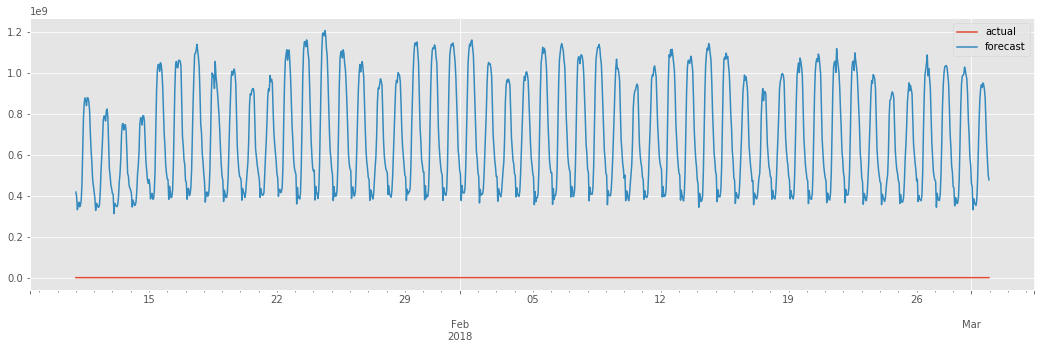

In [13]:
# create results dataframe
results = pd.DataFrame(index = forecasts.index)
results['actual'] = aggregate.values
results['forecast'] = forecasts*aggregate_year_transformer*aggregate_week_transformer
results = results[start+pd.Timedelta(hours=15):start+pd.Timedelta(days=num_days,hours=14)]

results.plot(figsize=(18,5))

mape = np.mean(np.abs((results['actual'] - results['forecast']) / results['actual']))*100
mape